# Initial Exploration of the Zhvi_AllHomes and TRI 2011-2015 US Data

An initial peek at the data present in the Zillow and TRI sets, doing a simple comparison of average home prices in a zip code and the total number of TRI reports for that zip code.

In [1]:
%pylab inline
import numpy, pandas
# The below option suppresses a warning about making changes diretly to a DataFrame
pandas.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read in the relevant data files
zhvi = pandas.read_csv("DATA/ZILLOW_DATA/Zip_Zhvi_AllHomes.csv")

tri2011 = pandas.read_csv("DATA/TRI_DATA/TRI_2011_US.csv", dtype={'NAICS_2': object, 'NAICS_3': object, 'NAICS_4': object, 'NAICS_5': object, 'PARENT_COMPANY_DB_NUMBER': object})
tri2012 = pandas.read_csv("DATA/TRI_DATA/TRI_2012_US.csv", dtype={'NAICS_2': object, 'NAICS_3': object, 'NAICS_4': object, 'NAICS_5': object, 'PARENT_COMPANY_DB_NUMBER': object})
tri2013 = pandas.read_csv("DATA/TRI_DATA/TRI_2013_US.csv", dtype={'TRIBE': object, 'PARENT_COMPANY_DB_NUMBER': object})
tri2014 = pandas.read_csv("DATA/TRI_DATA/TRI_2014_US.csv", dtype={'PARENT_COMPANY_DB_NUMBER': object})
tri2015 = pandas.read_csv("DATA/TRI_DATA/TRI_2015_US.csv", dtype={'PARENT_COMPANY_DB_NUMBER': object})

## Cleaning up the TRI data

A few notes on the ZIP codes found in the TRI datasets:

If a zip code has leading 0's in it, pandas drops the 0's as it reads in the data.
For example, 04276, the ZIP for Rumford, ME becomes 4276. Any ZIP shorter than 5 digits should be read as having leading 0's to bring it to 5 digits

In some cases, full 9 digit ZIPs are recorded. The trailing 4 digits are used to provide further specificity to the Postal Service within the leading 5 digit ZIP, and as such are not needed for our purposes. The method below takes a series of ZIPs from a TRI dataset and reformats any 9 digit ZIPs to 5 digits

### Sorting and Organizing
Once the ZIPs have been cleaned up, I'm re-ordering the data by ZIP code, as well as counting the total number of reports filed in a zip code per year in the TRI data

In [3]:
def cleanTriZIP(zips):
    """
    Re-formats 9 digit zip codes in the TRI dataset to 5 digit zip codes
    """
    for i in range(len(zips)):
        if zips[i] > 99999:
            zips[i] = numpy.int32((zips[i]/10000))

In [4]:
#Reformat 9 digit zips to 5 digits

triZIPs = []

triZIPs.append(tri2011.ZIP)
triZIPs.append(tri2012.ZIP)
triZIPs.append(tri2013.ZIP)
triZIPs.append(tri2014.ZIP)
triZIPs.append(tri2015.ZIP)

for z in triZIPs:
    cleanTriZIP(z)

In [5]:
sortedTriZIPs = []

for s in triZIPs:
    sortedTriZIPs.append(s.groupby(s.values).size())
    sortedTriZIPs[-1].index.name = 'ZIP'
    sortedTriZIPs[-1].name = 'REPORTS'

## Cleaning up the Zhvi_AllHomes data

My initial feeling is that the Zhvi dataset is much easier to work with. However, one change is that I have re-indexed the DataFrame so that each rows index is the ZIP code that it represents

In [6]:
# Re-index the zhvi DataFrame based off of zip code, which is called RegionName in the data set
zhvi.index = zhvi['RegionName']

### Dividing the Data
For this initial dive into the data, I am pulling out specifically the Zhvi data from NC, and looking between the years 2011-2015. For each year, I am taking the mean value from the Zhvi, since the data from the TRI is tracked annually

In [7]:
# From the initial DataFrame, copy out the data from NC
zhviNCar = zhvi[(zhvi['State'] == 'NC')].copy()

#Sort the zipcodes in ascending order
zhviNCar.sort_values('RegionName', inplace=True)

#Drop all columns outside of the 2011-2015 time frame
zhviNCar = zhviNCar.loc[:, '2011-01':'2015-12']

#Find the yearly mean prices for the zip codes
zhviNCarMeans = []
zhviNCarMeans.append(zhviNCar.T.iloc[0:12].mean())
zhviNCarMeans.append(zhviNCar.T.iloc[12:24].mean())
zhviNCarMeans.append(zhviNCar.T.iloc[24:36].mean())
zhviNCarMeans.append(zhviNCar.T.iloc[36:48].mean())
zhviNCarMeans.append(zhviNCar.T.iloc[48:60].mean())

## Finding the Overlap
There are ZIPs in the ZHVI data that aren't in the TRI data, and vice versa. To help draw meaningful conclusions it might be useful to find where the two data sets overlap

In [8]:
def findOverlap(tri, zhvi):
    """
    Takes equally sized lists as arguments. Each list is a series that is indexed by ZIP codes.
    Method returns two lists, indicating where one overlaps the other. For now, kept in two lists
    to make graphing easier. I would like to put this all in one dataframe but I'll figure that out later
    """
    #first list returns TRI data values that overlap the ZHVI data values
    TRIinZHVI = []
    #second list does the opposite.
    ZHVIinTRI = []
    
    for i in range(len(tri)):
        mask = zhvi[i].index.isin(tri[0].index)
        ZHVIinTRI.append(zhvi[i].where(mask).dropna())
        
        mask = tri[i].index.isin(ZHVIinTRI[i].index)
        TRIinZHVI.append(tri[i].where(mask).dropna())
    
    return TRIinZHVI, ZHVIinTRI

In [9]:
triNC, zhviTriNC = findOverlap(sortedTriZIPs, zhviNCarMeans)

### Graphing the Data

The first graph below shows the mean annual price per ZIP code from the Zhvi_AllHomes dataset
The second graph is the total number of TRI reports filed that same year in the same ZIP code.

I only am showing the first 20 here to give an idea of what might be possible. There are far to many records to actually show in one graph so we'll need to find a way to usefully show this data

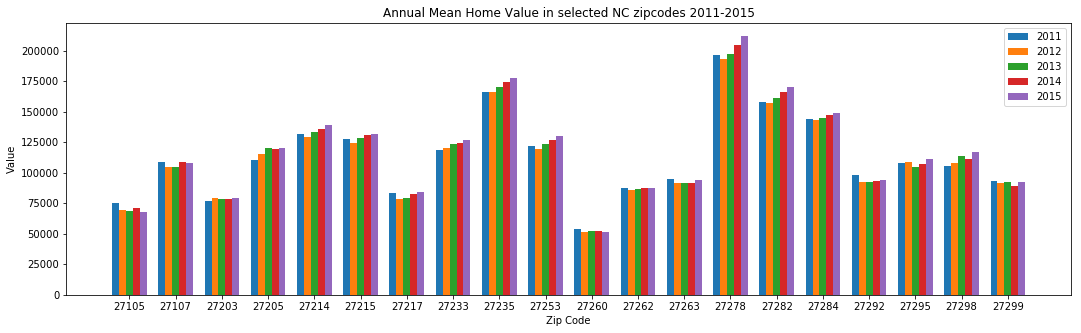

In [10]:
fig, ax = subplots(figsize = (18,5))

index = arange(20)
width = .15
offset = 0

for s in zhviTriNC:
    ax.bar(index + (width*offset), s.values[7:27], width)
    offset += 1

ax.set_xticks(index+(width*2))
ax.set_xticklabels(zhviTriNC[0].index[7:27])
ax.set_title('Annual Mean Home Value in selected NC zipcodes 2011-2015')
ax.set_xlabel('Zip Code')
ax.set_ylabel('Value')
ax.legend(['2011', '2012', '2013', '2014', '2015']);

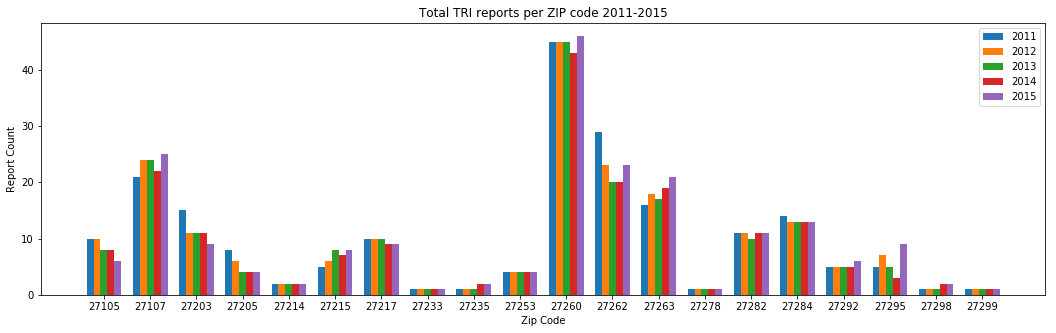

In [11]:
fig, ax = subplots(figsize = (18,5))

index = arange(20)
width = .15
offset = 0

for r in triNC:
    ax.bar(index + (width*offset), r.values[7:27], width)
    offset += 1

ax.set_xticks(index+(width*2))
ax.set_xticklabels(triNC[0].index[7:27])
ax.set_title('Total TRI reports per ZIP code 2011-2015')
ax.set_xlabel('Zip Code')
ax.set_ylabel('Report Count')
ax.legend(['2011', '2012', '2013', '2014', '2015']);

## More to come...

Well since my first graphs were totally wrong, I dont know what to say. The Mean Home Value has been corrected but the TRI report numbers are still off.